# Low-Level TensorFlow API

In this notebook you will learn how to use TensorFlow's low-level API, then use it to build custom loss functions, as well as custom Keras layers and models.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
matplotlib 2.2.3
numpy 1.17.2
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Tensors and operations

You can browse through the code examples or jump directly to the exercises.

### Tensors

In [5]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [6]:
t.shape

TensorShape([2, 3])

In [7]:
t.dtype

tf.float32

### Indexing

In [8]:
t[:, 1:]

<tf.Tensor: id=4, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [9]:
t[..., 1, tf.newaxis]

<tf.Tensor: id=8, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

In [10]:
t + 10

<tf.Tensor: id=10, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [11]:
tf.square(t)

<tf.Tensor: id=11, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [12]:
t @ tf.transpose(t)

<tf.Tensor: id=14, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### To/From NumPy

In [13]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
a = np.array([[1., 2., 3.], [4., 5., 6.]])
tf.constant(a)

<tf.Tensor: id=15, shape=(2, 3), dtype=float64, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]])>

In [15]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Scalars

In [16]:
t = tf.constant(2.718)
t

<tf.Tensor: id=17, shape=(), dtype=float32, numpy=2.718>

In [17]:
t.shape

TensorShape([])

In [18]:
t.numpy()

2.718

### Conflicting Types

In [19]:
try:
    tf.constant(1) + tf.constant(1.0)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2] name: add/


In [20]:
try:
    tf.constant(1.0, dtype=tf.float64) + tf.constant(1.0)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:AddV2] name: add/


In [21]:
t = tf.constant(1.0, dtype=tf.float64)
tf.cast(t, tf.float32) + tf.constant(1.0)

<tf.Tensor: id=25, shape=(), dtype=float32, numpy=2.0>

### Strings

In [22]:
t = tf.constant("café")
t

<tf.Tensor: id=26, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [23]:
tf.strings.length(t)

<tf.Tensor: id=27, shape=(), dtype=int32, numpy=5>

In [24]:
tf.strings.length(t, unit="UTF8_CHAR")

<tf.Tensor: id=28, shape=(), dtype=int32, numpy=4>

In [25]:
tf.strings.unicode_decode(t, "UTF8")

<tf.Tensor: id=32, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [26]:
t = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [27]:
tf.strings.length(t, unit="UTF8_CHAR")

<tf.Tensor: id=34, shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [28]:
r = tf.strings.unicode_decode(t, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

### Ragged tensors

In [29]:
r = tf.ragged.constant([[11, 12], [21, 22, 23], [], [41]])
r

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41]]>

In [30]:
print(r)

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41]]>


In [31]:
print(r[1])

tf.Tensor([21 22 23], shape=(3,), dtype=int32)


In [32]:
print(r[1:2])

<tf.RaggedTensor [[21, 22, 23]]>


In [33]:
r2 = tf.ragged.constant([[51, 52], [], [71]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41], [51, 52], [], [71]]>


In [34]:
r3 = tf.ragged.constant([[13, 14, 15], [24], [], [42, 43]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[11, 12, 13, 14, 15], [21, 22, 23, 24], [], [41, 42, 43]]>


In [35]:
r.to_tensor()

<tf.Tensor: id=250, shape=(4, 3), dtype=int32, numpy=
array([[11, 12,  0],
       [21, 22, 23],
       [ 0,  0,  0],
       [41,  0,  0]], dtype=int32)>

### Sparse tensors

In [36]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [37]:
tf.sparse.to_dense(s)

<tf.Tensor: id=255, shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [38]:
s2 = s * 2.0

In [39]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [40]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: id=259, shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [41]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [42]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order [Op:SparseToDense]


In [43]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: id=268, shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Variables

In [44]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [45]:
v.value()

<tf.Tensor: id=278, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [46]:
v.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [47]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [48]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [49]:
v[1].assign([7., 8., 9.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 7.,  8.,  9.]], dtype=float32)>

In [50]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [51]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

In [52]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,   5.,   6.],
       [  1.,   2., 200.]], dtype=float32)>

### Devices

In [53]:
with tf.device("/cpu:0"):
    t = tf.constant([[1., 2., 3.], [4., 5., 6.]])

In [54]:
t.device

'/job:localhost/replica:0/task:0/device:CPU:0'

In [55]:
if tf.test.is_gpu_available():
    with tf.device("/gpu:0"):
        t2 = tf.constant([[1., 2., 3.], [4., 5., 6.]])
    print(t2.device)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [56]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 1.1)
Create an `my_mse()` function with two arguments: the true labels `y_true` and the model predictions `y_pred`. Make it return the mean squared error using TensorFlow operations. Note that you could write your own custom metrics in exactly the same way. **Tip**: recall that the MSE is the mean of the squares of prediction errors, which are the differences between the predictions and the labels, so you will need to use `tf.reduce_mean()` and `tf.square()`.

In [57]:
def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

### 1.2)
Compile the following model, passing it your custom loss function, then train it and evaluate it. **Tip**: don't forget to use the scaled sets.

In [58]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [59]:
model.compile(optimizer='adam', loss=my_mse)

In [60]:
model.fit(x=X_train_scaled, y=y_train, batch_size=128, epochs=50, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 1s 48us/sample - loss: 4.2047 - val_loss: 3.1474
Epoch 2/50
11610/11610 [==============================] - 0s 11us/sample - loss: 1.4024 - val_loss: 2.6811
Epoch 3/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.8166 - val_loss: 1.4990
Epoch 4/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.7070 - val_loss: 0.8111
Epoch 5/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.6411 - val_loss: 0.6338
Epoch 6/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.5891 - val_loss: 0.5700
Epoch 7/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.5456 - val_loss: 0.5174
Epoch 8/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.5107 - val_loss: 0.4985
Epoch 9/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.4816 - val_l

In [61]:
model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

32993.776084060075

### 1.3)
Try building and compiling the model again, this time adding `"mse"` (or equivalently `"mean_squared_error"` or `keras.losses.mean_squared_error`) to the list of additional metrics, then train the model and make sure the `my_mse` is equal to the standard `mse`.

In [62]:
model.compile(optimizer='adam', loss='mse')

In [63]:
model.fit(x=X_train_scaled, y=y_train, batch_size=128, epochs=50, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3452 - val_loss: 0.3447
Epoch 2/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3401 - val_loss: 0.3564
Epoch 3/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3392 - val_loss: 0.3208
Epoch 4/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3396 - val_loss: 0.4103
Epoch 5/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3378 - val_loss: 0.3327
Epoch 6/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3371 - val_loss: 0.4962
Epoch 7/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3391 - val_loss: 0.5005
Epoch 8/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.3381 - val_loss: 0.8926
Epoch 9/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3385 - val_l

In [64]:
model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

62432.270457848834

### 1.4)
If you want your code to be portable to other Python implementations of the Keras API, you should use the operations in `keras.backend` rather than TensorFlow operations directly. This package contains thin wrappers around the backend's operations (for example, `keras.backend.square()` simply calls `tf.square()`). Try reimplementing the `my_mse()` function this way and use it to train and evaluate your model again. **Tip**: people frequently define `K = keras.backend` to make their code more readable.

In [65]:
K = keras.backend

In [66]:
def keras_mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 
    

In [67]:
model.compile(optimizer='adam', loss=keras_mse)

In [68]:
model.fit(x=X_train_scaled, y=y_train, batch_size=128, epochs=50, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3228 - val_loss: 0.3226
Epoch 2/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3174 - val_loss: 0.3015
Epoch 3/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.3160 - val_loss: 0.3178
Epoch 4/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3151 - val_loss: 0.3061
Epoch 5/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3154 - val_loss: 0.3019
Epoch 6/50
11610/11610 [==============================] - 0s 10us/sample - loss: 0.3142 - val_loss: 0.3474
Epoch 7/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.3146 - val_loss: 0.3687
Epoch 8/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.3165 - val_loss: 0.4619
Epoch 9/50
11610/11610 [==============================] - 0s 11us/sample - loss: 0.3135 - val_l

In [69]:
model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

81107.39496124031

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

### 1.1)
Create an `my_mse()` function with two arguments: the true labels `y_true` and the model predictions `y_pred`. Make it return the mean squared error using TensorFlow operations. Note that you could write your own custom metrics in exactly the same way. **Tip**: recall that the MSE is the mean of the squares of prediction errors, which are the differences between the predictions and the labels, so you will need to use `tf.reduce_mean()` and `tf.square()`.

In [70]:
def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

### 1.2)
Compile your model, passing it your custom loss function, then train it and evaluate it. **Tip**: don't forget to use the scaled sets.

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [72]:
model.compile(loss=my_mse, optimizer="sgd")

In [73]:
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.7693 - val_loss: 4.9930
Epoch 2/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5023 - val_loss: 2.3464
Epoch 3/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4458 - val_loss: 0.3814
Epoch 4/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4134 - val_loss: 0.3712
Epoch 5/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4034 - val_loss: 0.3709
Epoch 6/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3913 - val_loss: 0.3734
Epoch 7/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3943 - val_loss: 0.3712
Epoch 8/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3847 - val_loss: 0.3690
Epoch 9/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3775 - val_l

In [74]:
model.evaluate(X_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3662279457084892

### 1.3)
Try building and compiling the model again, this time adding `"mse"` (or equivalently `"mean_squared_error"` or `keras.losses.mean_squared_error`) to the list of additional metrics, then train the model and make sure the `my_mse` is equal to the standard `mse`.

In [75]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss=my_mse, optimizer="sgd", metrics=["mean_squared_error"])
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 9.2085 - val_mean_squared_error: 9.2085
Epoch 2/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5118 - mean_squared_error: 0.5118 - val_loss: 21.3391 - val_mean_squared_error: 21.3391
Epoch 3/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5085 - mean_squared_error: 0.5085 - val_loss: 0.4383 - val_mean_squared_error: 0.4383
Epoch 4/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4289 - mean_squared_error: 0.4289 - val_loss: 0.3903 - val_mean_squared_error: 0.3903
Epoch 5/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4095 - mean_squared_error: 0.4095 - val_loss: 0.3763 - val_mean_squared_error: 0.3763
Epoch 6/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4036 - mean_squared_e

[0.37428467227507006, 0.3742846]

### 1.4)
If you want your code to be portable to other Python implementations of the Keras API, you should use the operations in `keras.backend` rather than TensorFlow operations directly. This package contains thin wrappers around the backend's operations (for example, `keras.backend.square()` simply calls `tf.square()`). Try reimplementing the `my_mse()` function this way and use it to train and evaluate your model again. **Tip**: people frequently define `K = keras.backend` to make their code more readable.

In [76]:
def my_portable_mse(y_true, y_pred):
    K = keras.backend
    return K.mean(K.square(y_pred - y_true))

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss=my_portable_mse, optimizer="sgd", metrics=["mean_squared_error"])
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.7594 - mean_squared_error: 0.7594 - val_loss: 3.7875 - val_mean_squared_error: 3.7875
Epoch 2/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4881 - mean_squared_error: 0.4881 - val_loss: 17.9503 - val_mean_squared_error: 17.9503
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6059 - mean_squared_error: 0.6059 - val_loss: 3.3533 - val_mean_squared_error: 3.3533
Epoch 4/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.3751 - val_mean_squared_error: 0.3751
Epoch 5/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3986 - mean_squared_error: 0.3986 - val_loss: 0.3654 - val_mean_squared_error: 0.3654
Epoch 6/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3990 - mean_squared_e

[0.5032075428916503, 0.5032075]

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Custom layer

### 2.1)
Some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If you want to create a custom layer without any weights, the simplest option is to create a `keras.layers.Lambda` layer and pass it the function to perform. For example, try creating a custom layer that applies the softplus function (log(exp(X) + 1), and try calling this layer like a regular function.

**Tip**: you can use `tf.math.softplus()` rather than computing the log and the exponential manually.

In [78]:

sp = keras.layers.Lambda(tf.math.softplus)

### 2.2)
Create a regression model like in exercise 1, but add your softplus layer at the top (i.e., after the existing 1-unit dense layer). This can be useful to ensure that your model never predicts negative values.

In [79]:
model = keras.models.Sequential([
        keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
        keras.layers.Dense(1), 
        keras.layers.Lambda(tf.math.softplus),
        ])

In [80]:
model.compile(optimizer='adam', loss=keras_mse)

In [81]:
model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 62us/sample - loss: 1.1558 - val_loss: 0.5780
Epoch 2/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.5267 - val_loss: 0.4292
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4297 - val_loss: 0.3773
Epoch 4/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3962 - val_loss: 0.3566
Epoch 5/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3780 - val_loss: 1.1627
Epoch 6/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3821 - val_loss: 0.3412
Epoch 7/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3632 - val_loss: 0.3633
Epoch 8/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3606 - val_loss: 0.3339
Epoch 9/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3558 - val_l

### 2.3)
Alternatively, try using this softplus layer as the activation function of the output layer.

**Notes**:
* setting a layer's activation function is just a handy way of adding an extra weightless layer.
* Keras supports the softplus activation function out of the box:
  * set `activation="softplus"`
  * or set `activation=keras.activations.softplus`
  * or add a `keras.layers.Activation("softplus")` layer to your model.

In [82]:
model = keras.Sequential([
                            keras.layers.Dense(30, activation='softplus'),
                            keras.layers.Dense(1)
                        ])
model.compile(optimizer='adagrad', loss='mse', metrics=[my_mse, my_portable_mse])

In [83]:
model.fit(X_train_scaled, y_train, batch_size=32, epochs=10, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 73us/sample - loss: 4.1214 - my_mse: 4.1214 - my_portable_mse: 4.1214 - val_loss: 3.4848 - val_my_mse: 3.4844 - val_my_portable_mse: 3.4844
Epoch 2/10
11610/11610 [==============================] - 0s 42us/sample - loss: 2.7642 - my_mse: 2.7635 - my_portable_mse: 2.7635 - val_loss: 2.4885 - val_my_mse: 2.4883 - val_my_portable_mse: 2.4883
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 2.2008 - my_mse: 2.2010 - my_portable_mse: 2.2010 - val_loss: 1.9854 - val_my_mse: 1.9852 - val_my_portable_mse: 1.9852
Epoch 4/10
11610/11610 [==============================] - 0s 41us/sample - loss: 1.8726 - my_mse: 1.8726 - my_portable_mse: 1.8726 - val_loss: 1.6921 - val_my_mse: 1.6920 - val_my_portable_mse: 1.6920
Epoch 5/10
11610/11610 [==============================] - 0s 39us/sample - loss: 1.6592 - my_mse: 1.6586 - my_portable_mse: 1.6586 - val_loss: 1.50

In [84]:
model.evaluate(X_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.1901289664497672, 1.1955659, 1.1955659]

### 2.4)
Now let's create a custom layer with its own weights. Use the following template to create a `MyDense` layer that computes $\phi(\mathbf{X} \mathbf{W}) + \mathbf{b}$, where $\phi$ is the (optional) activation function, $\mathbf{X}$ is the input data, $\mathbf{W}$ represents the kernel (i.e., connection weights), and $\mathbf{b}$ represents the biases, then train and evaluate a model using this instead of a regular `Dense` layer.

**Tips**:
* The constructor `__init__()`:
  * It must have all your layer's hyperparameters as arguments, and save them to instance variables. You will need the number of `units` and the optional `activation` function. To support all kinds of activation functions (strings or functions), simply create a `keras.layers.Activation` passing it the `activation` argument.
  * The `**kwargs` argument must be passed to the base class's constructor (`super().__init__()`) so your class can support the `input_shape` argument, and more.
* The `build()` method:
  * The `build()` method will be called automatically by Keras when it knows the shape of the inputs. Note that the argument should really be called `batch_input_shape` since it includes the batch size.
  * You must call `self.add_weight()` for each weight you want to create, specifying its `name`, `shape` (which often depends on the `input_shape`), how to initialize it, and whether or not it is `trainable`. You need two weights: the `kernel` (connection weights) and the `biases`. The kernel must be initialized randomly. The biases are usually initialized with zeros. **Note**: you can find many initializers in `keras.initializers`.
  * Do not forget to call `super().build()`, so Keras knows that the model has been built.
  * Note: you could create the weights in the constructor, but it is preferable to create them in the `build()` method, because users of your class may not always know the `input_shape` when creating the model. The first time the model is used on some actual data, the `build()` method will automatically be called with the actual `input_shape`.
* The `call()` method:
  * This is where to code your layer's actual computations. As before, you can use TensorFlow operations directly, or use `keras.backend` operations if you want the layer to be portable to other Keras implementations.
* The `compute_output_shape()` method:
  * You do not need to implement this method when using tf.keras, as the `Layer` class provides a good implementation.
  * However, if want to port your code to another Keras implementation (such as keras-team), and if the output shape is different from the input shape, then you need to implement this method. Note that the input shape is actually the batch input shape, and the ouptut shape must be the batch output shape.

In [85]:
# This template was copied from https://keras.io/layers/writing-your-own-keras-layers/
# I just removed the imports and replaced Layer with keras.layers.Layer.

class MyLayer(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 – Solution

### 2.1)
Some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If you want to create a custom layer without any weights, the simplest option is to create a `keras.layers.Lambda` layer and pass it the function to perform. For example, try creating a custom layer that applies the softplus function (log(exp(X) + 1), and try calling this layer like a regular function.

In [86]:
my_softplus = keras.layers.Lambda(lambda X: tf.nn.softplus(X))

In [87]:
my_softplus([-10., -5., 0., 5., 10.])

<tf.Tensor: id=113769, shape=(5,), dtype=float32, numpy=
array([4.5417706e-05, 6.7153489e-03, 6.9314718e-01, 5.0067153e+00,
       1.0000046e+01], dtype=float32)>

### 2.2)
Create a regression model like in exercise 1, but add your softplus layer at the top (i.e., after the existing 1-unit dense layer). This can be useful to ensure that your model never predicts negative values.

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
    my_softplus
])
model.compile(loss=my_portable_mse, optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 54us/sample - loss: 0.8772 - val_loss: 0.4885
Epoch 2/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4741 - val_loss: 0.4119
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4394 - val_loss: 0.3887
Epoch 4/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4162 - val_loss: 0.3795
Epoch 5/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4059 - val_loss: 0.3707
Epoch 6/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3977 - val_loss: 0.3639
Epoch 7/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3911 - val_loss: 0.3571
Epoch 8/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3838 - val_loss: 0.3521
Epoch 9/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3793 - val_l

0.36721492571424147

### 2.3)
Alternatively, try using this softplus layer as the activation function of the output layer.

In [89]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation=my_softplus)
#   A few alternatives...
#   keras.layers.Dense(1, activation=tf.function(lambda X: my_softplus(X)))
#   keras.layers.Dense(1, activation="softplus")
#   keras.layers.Dense(1, activation=keras.activations.softplus)
#   keras.layers.Dense(1), keras.layers.Activation("softplus")
])

model.compile(loss=my_portable_mse, optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 54us/sample - loss: 0.9833 - val_loss: 0.4472
Epoch 2/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4509 - val_loss: 0.3908
Epoch 3/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4098 - val_loss: 0.3657
Epoch 4/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3917 - val_loss: 0.3539
Epoch 5/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3860 - val_loss: 0.3506
Epoch 6/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3755 - val_loss: 0.3452
Epoch 7/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3706 - val_loss: 0.3408
Epoch 8/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3658 - val_loss: 0.3446
Epoch 9/10
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3612 - val_l

0.3527578784513843

### 2.4)
Now let's create a custom layer with its own weights. Use the following template to create a `MyDense` layer that computes $\phi(\mathbf{X} \mathbf{W}) + \mathbf{b}$, where $\phi$ is the (optional) activation function, $\mathbf{X}$ is the input data, $\mathbf{W}$ represents the kernel (i.e., connection weights), and $\mathbf{b}$ represents the biases, then train and evaluate a model using this instead of a regular `Dense` layer.

In [90]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    @tf.function   # required, see https://github.com/tensorflow/tensorflow/issues/25096
    def call(self, X):
        return self.activation(X @ self.kernel + self.biases)

In [91]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=X_train.shape[1:]),
    MyDense(1)
])

In [92]:
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 64us/sample - loss: 1.1140 - val_loss: 0.5415
Epoch 2/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5136 - val_loss: 0.4384
Epoch 3/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4495 - val_loss: 0.4020
Epoch 4/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4336 - val_loss: 0.3975
Epoch 5/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4242 - val_loss: 0.4031
Epoch 6/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4184 - val_loss: 0.4059
Epoch 7/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4118 - val_loss: 0.4155
Epoch 8/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4056 - val_loss: 0.4086
Epoch 9/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3998 - val_l

0.3814898203047671

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – TensorFlow Functions

### 3.1)
Examine and run the following code examples.

In [93]:
def scaled_elu(z, scale=1.0, alpha=1.0):
    is_positive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_positive, z, alpha * tf.nn.elu(z))

In [94]:
scaled_elu(tf.constant(-3.))

<tf.Tensor: id=145723, shape=(), dtype=float32, numpy=-0.95021296>

In [95]:
scaled_elu(tf.constant([-3., 2.5]))

<tf.Tensor: id=145732, shape=(2,), dtype=float32, numpy=array([-0.95021296,  2.5       ], dtype=float32)>

In [96]:
scaled_elu_tf = tf.function(scaled_elu)
scaled_elu_tf

In [97]:
scaled_elu_tf(tf.constant(-3.))

<tf.Tensor: id=145747, shape=(), dtype=float32, numpy=-0.95021296>

In [98]:
scaled_elu_tf(tf.constant([-3., 2.5]))

<tf.Tensor: id=145761, shape=(2,), dtype=float32, numpy=array([-0.95021296,  2.5       ], dtype=float32)>

In [99]:
scaled_elu_tf.python_function is scaled_elu

True

In [100]:
%timeit scaled_elu(tf.random.normal((1000, 1000)))

9.69 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
%timeit scaled_elu_tf(tf.random.normal((1000, 1000)))

9.32 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [102]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [103]:
display_tf_code(scaled_elu)

```python
def tf__scaled_elu(z, scale=None, alpha=None):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('scaled_elu', 'scaled_elu_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as scaled_elu_scope:
    is_positive = ag__.converted_call(tf.greater_equal, scaled_elu_scope.callopts, (z, 0.0), None, scaled_elu_scope)
    do_return = True
    retval_ = scaled_elu_scope.mark_return_value(scale * ag__.converted_call(tf.where, scaled_elu_scope.callopts, (is_positive, z, alpha * ag__.converted_call(tf.nn.elu, scaled_elu_scope.callopts, (z,), None, scaled_elu_scope)), None, scaled_elu_scope))
  do_return,
  return ag__.retval(retval_)

```

In [104]:
var = tf.Variable(0)

@tf.function
def add_21():
    return var.assign_add(21)

@tf.function
def times_2():
    return var.assign(var * 2)

In [105]:
add_21()
times_2()

<tf.Tensor: id=162829, shape=(), dtype=int32, numpy=42>

In [106]:
def times_4(x):
    return 4. * x

@tf.function
def times_4_plus_22(x):
    return times_4(x) + 22.

In [107]:
times_4_plus_22(tf.constant(5.))

<tf.Tensor: id=162840, shape=(), dtype=float32, numpy=42.0>

Compute 1 + 1/2 + 1/4 + ...: the order of execution of the operations with side-effects (e.g., `assign()`) is preserved (in TF 1.x, `tf.control_dependencies()` was needed in such cases):

In [108]:
total = tf.Variable(0.)
increment = tf.Variable(1.)

@tf.function
def converge_to_2(n_iterations):
    for i in tf.range(n_iterations):
        total.assign_add(increment)
        increment.assign(increment / 2.0)
    return total

converge_to_2(20)

<tf.Tensor: id=162914, shape=(), dtype=float32, numpy=1.9999981>

### 3.2)
Write a function that computes the sum of squares from 1 to n, where n is an argument. Convert it to a graph function by using `tf.function` as a decorator. Display the code generated by autograph using the `display_tf_code()` function. Use `%timeit` to see how must faster the TensorFlow `Function` is compared to the Python function.

### 3.3)
Examine and run the following code examples.

In [109]:
@tf.function
def square(x):
    print("Calling", x)  # part of the TF Function
    tf.get_logger().warning("Tracing")  # NOT part of the TF Function
    return tf.square(x)

In [110]:
for i in range(5):
    square(tf.constant(i))

Calling Tensor("x:0", shape=(), dtype=int32)


In [111]:
for i in range(5):
    square(tf.constant(i, dtype=tf.float32))

Calling Tensor("x:0", shape=(), dtype=float32)


In [112]:
for i in range(5):
    square(tf.constant([i, i], dtype=tf.float32))

Calling Tensor("x:0", shape=(2,), dtype=float32)


In [113]:
# WARNING: when passing non-tensor values, a trace happens for any new value!
# This is to allow optimization in case this value determines e.g., number of layers.
for i in range(5):
    square(i)

Calling 0
Calling 1
Calling 2


Calling 3
Calling 4


### 3.4)
When you give Keras a custom loss function, it actually creates a graph function based on it, and then uses that graph function during training. The same is true of custom metric functions, and the `call()` method of custom layers and models. Create a `my_mse()` function, like you did earlier, but add an instruction to log a message inside it (do *not* use `print()`!), and verify that the message is only logged once when you compile and train the model. Optionally, you can also find out when Keras converts custom metrics, layers and models.

### 3.5)
Examine the following function, and try to call it with various argument types and shapes. Notice that only tensors of type `int32` and one dimension (of any size) are accepted now that we have specified the `input_signature`.

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
Examine the code examples.

Done.

### 3.2)
Write a function that computes the sum of squares from 1 to n, where n is an argument. Convert it to a graph function by using `tf.function` as a decorator. Display the code generated by autograph using the `display_tf_code()` function. Use `%timeit` to see how must faster the TensorFlow `Function` is compared to the Python function.

In [ ]:
@tf.function
def sum_squares(n):
    s = tf.constant(0)
    for i in range(1, n + 1):
        s = s + i ** 2
    return s

In [ ]:
sum_squares(tf.constant(5))

In [ ]:
display_tf_code(sum_squares.python_function)

In [ ]:
%timeit sum_squares(10000)

In [ ]:
%timeit sum_squares.python_function(10000)

### 3.3)
Examine the code examples.

Done.

### 3.4)
When you give Keras a custom loss function, it actually creates a graph function based on it, and then uses that graph function during training. The same is true of custom metric functions, and the `call()` method of custom layers and models. Create a `my_mse()` function, like you did earlier, but add an instruction to log a message inside it (do *not* use `print()`!), and verify that the message is only logged once when you compile and train the model. Optionally, you can also find out when Keras converts custom metrics, layers and models.

In [112]:
# Custom loss function
def my_mse(y_true, y_pred):
    tf.get_logger().warning("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [113]:
# Custom metric function
def my_mae(y_true, y_pred):
    tf.get_logger().warning("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [114]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    def call(self, X):
        tf.get_logger().warning("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [115]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        tf.get_logger().warning("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [116]:
model.compile(loss=my_mse, optimizer="sgd", metrics=[my_mae])

In [117]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 81us/sample - loss: 0.9880 - my_mae: 0.7003 - val_loss: 2.5640 - val_my_mae: 0.5657
Epoch 2/2
11610/11610 [==============================] - 1s 47us/sample - loss: 0.6829 - my_mae: 0.5914 - val_loss: 0.6591 - val_my_mae: 0.5255
5160/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5419197117635446, 0.5327559]

Notice that each custom function is traced just once, except for the metric function. That's a bit odd.

In [127]:
class tomModel(tf.keras.models.Model):
    def __init__(self):
        super(tomModel, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(30, activation='tanh')
        self.output_ = tf.keras.layers.Dense(1)
    
    def call(self, input):
        tf.get_logger().warning('Tracing Model.call()')
        hidden1 = self.hidden1(input)
        output = self.output_(hidden1)
        return output
    
model = tomModel()

In [128]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [129]:
model.fit(X_train_scaled, y_train, batch_size=64, epochs=10, validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 69us/sample - loss: 3.2500 - mae: 1.4830 - val_loss: 1.0525 - val_mae: 0.7744
Epoch 2/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6442 - mae: 0.5796 - val_loss: 0.4739 - val_mae: 0.4986
Epoch 3/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4857 - mae: 0.5125 - val_loss: 0.4340 - val_mae: 0.4833
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4681 - mae: 0.5020 - val_loss: 0.4243 - val_mae: 0.4785
Epoch 5/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4597 - mae: 0.4985 - val_loss: 0.4189 - val_mae: 0.4763
Epoch 6/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4538 - mae: 0.4950 - val_loss: 0.4141 - val_mae: 0.4682
Epoch 7/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4485 - mae: 0.4911 - val_loss: 0.4

### 3.5)
Examine the following function, and try to call it with various argument types and shapes. Notice that only tensors of type `int32` and one dimension (of any size) are accepted now that we have specified the `input_signature`.

In [93]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

In [94]:
cube(tf.constant([1, 2, 3]))

<tf.Tensor: id=121541, shape=(3,), dtype=int32, numpy=array([ 1,  8, 27], dtype=int32)>

In [95]:
cube(tf.constant([1, 2, 3, 4, 5]))

<tf.Tensor: id=121543, shape=(5,), dtype=int32, numpy=array([  1,   8,  27,  64, 125], dtype=int32)>

In [96]:
try:
    cube([1, 2, 3])
except ValueError as ex:
    print(ex)

In [97]:
try:
    cube(tf.constant([1., 2., 3]))
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name='x'))


In [98]:
try:
    cube(tf.constant([[1, 2], [3, 4]]))
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32))
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name='x'))


![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Function Graphs

### 4.1)
Examine and run the following code examples.

In [99]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name="x")])
def cube(z):
    return tf.pow(z, 3)

In [100]:
cube_func_int32 = cube.get_concrete_function(tf.TensorSpec([None], tf.int32))
cube_func_int32

In [101]:
cube_func_int32 is cube.get_concrete_function(tf.TensorSpec([5], tf.int32))

True

In [102]:
cube_func_int32 is cube.get_concrete_function(tf.constant([1, 2, 3]))

True

In [103]:
cube_func_int32.graph

### 4.2)
The function's graph is represented on the following diagram. Call the graph's `get_operations()` method to get the list of operations. Each operation has an `inputs` attribute that returns an iterator over its input tensors (these are symbolic: contrary to tensors we have used up to now, they have no value). It also has an `outputs` attribute that returns the list of output tensors. Each tensor has an `op` attribute that returns the operation it comes from. Try navigating through the graph using these methods and attributes.

<img src="images/cube_graph.png" width="600" />

### 4.3)
Each operation has a default name, such as `"pow"` (you can override it by setting the `name` attribute when you call the operation). In case of a name conflict, TensorFlow adds an underscore and anindex to make the name unique (e.g. `"pow_1"`). Moreover, each tensor has the same name as the operation that outputs it, followed by a colon `:` and the tensor's `index` (e.g., `"pow:0"`). Most operations have a single output tensor, so most tensors have a name that ends with `:0`. Try using `get_operation_by_name()` and `get_tensor_by_name()` to access any op and tensor you wish.

### 4.4)
Call the graph's `as_graph_def()` method and print the output. This is a protobuf representation of the computation graph: it is what makes TensorFlow models so portable.

### 4.5)
Get the concrete function's `function_def`, and look at its `signature`. This shows the names and types of the nodes in the graph that correspond to the function's inputs and outputs. This will come in handy when you deploy models to TensorFlow Serving or Google Cloud ML Engine.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
Examine the code examples.

Done.

### 4.2)
The function's graph is represented on the following diagram. Call the graph's `get_operations()` method to get the list of operations. Each operation has an `inputs` attribute that returns an iterator over its input tensors (these are symbolic: contrary to tensors we have used up to now, they have no value). It also has an `outputs` attribute that returns the list of output tensors. Each tensor has an `op` attribute that returns the operation it comes from. Try navigating through the graph using these methods and attributes.

<img src="images/cube_graph.png" width="600" />

In [104]:
cube_func_int32.graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Pow/y' type=Const>,
 <tf.Operation 'Pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [105]:
pow_op = cube_func_int32.graph.get_operations()[2]
pow_op

<tf.Operation 'Pow' type=Pow>

In [106]:
pow_in = list(pow_op.inputs)
pow_in

[<tf.Tensor 'x:0' shape=(None,) dtype=int32>,
 <tf.Tensor 'Pow/y:0' shape=() dtype=int32>]

In [107]:
pow_out = list(pow_op.outputs)
pow_out

[<tf.Tensor 'Pow:0' shape=(None,) dtype=int32>]

In [108]:
pow_in = list(pow_op.inputs)
pow_in

[<tf.Tensor 'x:0' shape=(None,) dtype=int32>,
 <tf.Tensor 'Pow/y:0' shape=() dtype=int32>]

In [109]:
pow_in[0].op

<tf.Operation 'x' type=Placeholder>

### 4.3)
Each operation has a default name, such as `"pow"` (you can override it by setting the `name` attribute when you call the operation). In case of a name conflict, TensorFlow adds an underscore and anindex to make the name unique (e.g. `"pow_1"`). Moreover, each tensor has the same name as the operation that outputs it, followed by a colon `:` and the tensor's `index` (e.g., `"pow:0"`). Most operations have a single output tensor, so most tensors have a name that ends with `:0`. Try using `get_operation_by_name()` and `get_tensor_by_name()` to access any op and tensor you wish.

In [110]:
cube_func_int32.graph.get_operation_by_name("x")

<tf.Operation 'x' type=Placeholder>

In [111]:
cube_func_int32.graph.get_tensor_by_name("x:0")

<tf.Tensor 'x:0' shape=(None,) dtype=int32>

### 4.4)
Call the graph's `as_graph_def()` method and print the output. This is a protobuf representation of the computation graph: it is what makes TensorFlow models so portable.

In [112]:
cube_func_int32.graph.as_graph_def()

node {
  name: "x"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "x"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
node {
  name: "Pow/y"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 3
      }
    }
  }
}
node {
  name: "Pow"
  op: "Pow"
  input: "x"
  input: "Pow/y"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
node {
  name: "Identity"
  op: "Identity"
  input: "Pow"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
versions {
  producer: 119
}

### 4.5)
Get the concrete function's `function_def`, and look at its `signature`. This shows the names and types of the nodes in the graph that correspond to the function's inputs and outputs. This will come in handy when you deploy models to TensorFlow Serving or Google Cloud ML Engine.

In [113]:
cube_func_int32.function_def.signature

name: "__inference_cube_121554"
input_arg {
  name: "x"
  type: DT_INT32
}
output_arg {
  name: "identity"
  type: DT_INT32
}

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – Autodiff

### 5.1)
Examine and run the following code examples.

In [114]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

In [115]:
def approximate_derivative(f, x, eps=1e-3):
    return (f(x + eps) - f(x - eps)) / (2. * eps)

In [116]:
approximate_derivative(f, 1.0) # true derivative = 8

7.999999999999119

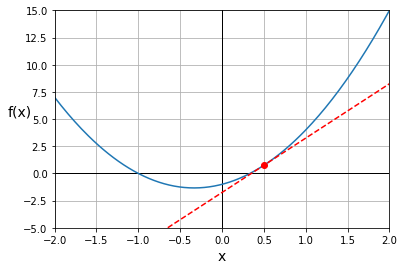

In [117]:
xs = np.linspace(-2, 2, 200)
fs = f(xs)
x0 = 0.5
df_x0 = approximate_derivative(f, x0)
tangent_x0 = df_x0 * (xs - x0) + f(x0)
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot([0, 0], [-5, 15], "k-", linewidth=1)
plt.plot(xs, fs)
plt.plot(xs, tangent_x0, "r--")
plt.plot(x0, f(x0), "ro")
plt.grid(True)
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14, rotation=0)
plt.axis([-2, 2, -5, 15])
plt.show()

In [118]:
def g(x1, x2):
    return (x1 + 5) * (x2 ** 2)

In [119]:
def approximate_gradient(f, x1, x2, eps=1e-3):
    df_x1 = approximate_derivative(lambda x: f(x, x2), x1, eps)
    df_x2 = approximate_derivative(lambda x: f(x1, x), x2, eps)
    return df_x1, df_x2

In [120]:
approximate_gradient(g, 2.0, 3.0) # true gradient = (9, 42)

(8.999999999993236, 41.999999999994486)

In [121]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)
grads = tape.gradient(z, [x1, x2])
grads

[<tf.Tensor: id=121580, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=121586, shape=(), dtype=float32, numpy=42.0>]

In [122]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
try:
    dz_x2 = tape.gradient(z, x2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [123]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
dz_x2 = tape.gradient(z, x2)
del tape
dz_x1, dz_x2

(<tf.Tensor: id=121638, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=121652, shape=(), dtype=float32, numpy=42.0>)

In [124]:
x1 = tf.constant(2.0) # <= not Variable
x2 = tf.constant(3.0) # <= not Variable
with tf.GradientTape() as tape:
    z = g(x1, x2)

grads = tape.gradient(z, [x1, x2])
grads

[None, None]

In [125]:
x1 = tf.constant(2.0)
x2 = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x1)
    tape.watch(x2)
    z = g(x1, x2)

grads = tape.gradient(z, [x1, x2])
grads

[<tf.Tensor: id=121668, shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: id=121674, shape=(), dtype=float32, numpy=42.0>]

In [126]:
x = tf.Variable(5.0)
with tf.GradientTape() as tape:
    z1 = 3 * x
    z2 = x ** 2
tape.gradient([z1, z2], x) # dz1_x + dz2_x = 3 + 2x = 3 + 2*5 = 13

<tf.Tensor: id=121697, shape=(), dtype=float32, numpy=13.0>

In [127]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = g(x1, x2)
    jacobians = jacobian_tape.gradient(z, [x1, x2])
hessians = [hessian_tape.gradient(jacobian, [x1, x2])
            for jacobian in jacobians]
del hessian_tape
hessians

[[None, <tf.Tensor: id=121734, shape=(), dtype=float32, numpy=6.0>],
 [<tf.Tensor: id=121745, shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: id=121743, shape=(), dtype=float32, numpy=14.0>]]

### 5.2)
Implement Gradient Descent manually to find the value of `x` that minimizes the following function `f(x)`.

**Tips**:
* Define a variable `x` and initialize it to 0.
* Define the `learning_rate` (e.g., 0.1).
* Write a loop that will repeatedly (1) compute the gradient of `f` (actually a derivative in this case) at the current value of `x`, and (2) tweak `x` slightly in the opposite direction (by subtracting `learning_rate * df_dx`). You can use `x.assign_sub(...)` for this.
* Using calculus, we can find that the algorithm should converge to $x = -\frac{1}{3}$. Indeed, the derivative of $f(x) = 3 x^2 + 2x -1$ is $f'(x) = 6x + 2$, so the minimum is reached when $f'(x) = 0$ (slope is 0), so $6x + 2 = 0$, which leads to $x = -\frac{1}{3}$.


In [128]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

### 5.3)
Now use an `SGD` optimizer instead of manually tweaking `x`.

**Tips**:
* You first need to create an `SGD` optimizer, optionally specifying the learning_rate (e.g., `lr=0.1`).
* Next replace the manual tweaking of `x` in your previous code to use `optimizer.apply_gradients()` instead. You need to pass it a list of gradient/variable pairs (just one pair in this example).

### 5.4)
Create a `Sequential` model for the California housing problem (no need to compile it), and train it using your own training loop, instead of using `fit()`. Evaluate your model on the validation set at the end of each epoch, and display the result.

**Tips**:
* You can use the following `random_batch()` function to get a new batch of training data at each iteration (the Data API would be much preferable, as we will see in the next notebook).
* You can use the model like a function to make predictions: `y_pred = model(X_batch)`
* You can use `keras.losses.mean_squared_error()` to compute the loss. Note that it returns one loss per instance, so you need to use `tf.reduce_mean()` to get the mean loss. 
* You can use `model.trainable_variables` to get the full list of trainable variables in your model.
* You can use `zip(gradients, variables)` to create a list containing all the gradient/variable pairs.

In [ ]:
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(0, len(X), size=batch_size)
    return X[idx], y[idx]

### 5.5)
Examine and run the following code examples, then update your training loop to display the training loss at each iteration.

**Tips**:
* You can use a `keras.metrics.MeanSquaredError` instance to efficiently track the running mean squared error at each iteration.
* Make sure you reset the metric's states at the start of each epoch.
* You can use `print("\r", mse, end="")` to display the MSE on the same line at each iteration.

In [ ]:
metric = keras.metrics.MeanSquaredError()
metric([5.], [2.])  # error = (2 - 5)**2 = 9
metric([0.], [1.])  # error = (1 - 0)**2 = 1
metric.result()     # mean error = (9 + 1) / 2 = 5

In [ ]:
metric.reset_states()
metric.result()

In [ ]:
metric([1.], [3.])  # error = (3 - 1)**2 = 4
metric.result()     # mean error = 4 / 1 = 4

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Examine the code examples.

Done

### 5.2)
Implement Gradient Descent manually to find the value of `x` that minimizes the following function `f(x)`.

In [ ]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

In [ ]:
learning_rate = 0.1
x = tf.Variable(0.0)

for iteration in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    x.assign_sub(learning_rate * dz_dx)
x

### 5.3)
Now use an `SGD` optimizer instead of manually tweaking `x`.

In [ ]:
x = tf.Variable(0.0)
optimizer = keras.optimizers.SGD(lr=0.1)

for iteration in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    optimizer.apply_gradients([(dz_dx, x)])
x

### 5.4)
Create a `Sequential` model for the California housing problem (no need to compile it), and train it using your own training loop, instead of using `fit()`. Evaluate your model on the validation set at the end of each epoch, and display the result.

In [87]:
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(0, len(X), size=batch_size)
    return X[idx], y[idx]

In [88]:
epochs = 10
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.mean_squared_error

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        grads = tape.gradient(loss, model.variables)
        grads_and_vars = zip(grads, model.variables)
        optimizer.apply_gradients(grads_and_vars)
    y_pred = model(X_valid_scaled)
    valid_loss = tf.reduce_mean(loss_fn(y_valid, y_pred))
    print("Epoch", epoch, "valid mse:", valid_loss.numpy())

Epoch 0 valid mse: 7.361124
Epoch 1 valid mse: 0.6335891
Epoch 2 valid mse: 0.5728289
Epoch 3 valid mse: 0.5336157
Epoch 4 valid mse: 0.5098443
Epoch 5 valid mse: 0.50830084
Epoch 6 valid mse: 0.45629823
Epoch 7 valid mse: 0.4431363
Epoch 8 valid mse: 0.4262458
Epoch 9 valid mse: 0.43079847


### 5.5)
Examine and run the following code examples, then update your training loop to display the training loss at each iteration.

In [89]:
metric = keras.metrics.MeanSquaredError()
metric([5.], [2.])  # error = (2 - 5)**2 = 9
metric([0.], [1.])  # error = (1 - 0)**2 = 1
metric.result()     # mean error = (9 + 1) / 2 = 5

<tf.Tensor: id=624142, shape=(), dtype=float32, numpy=5.0>

In [90]:
metric.reset_states()
metric.result()

<tf.Tensor: id=624148, shape=(), dtype=float32, numpy=0.0>

In [91]:
metric([1.], [3.])  # error = (3 - 1)**2 = 4
metric.result()     # mean error = 4 / 1 = 4

<tf.Tensor: id=624164, shape=(), dtype=float32, numpy=4.0>

In [92]:
epochs = 10
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.mean_squared_error
metric = keras.metrics.MeanSquaredError()  # ADDED

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    metric.reset_states()  # ADDED
    for step in range(steps_per_epoch):
        X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            metric(y_batch, y_pred)  # ADDED
        grads = tape.gradient(loss, model.trainable_variables)
        grads_and_vars = zip(grads, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars)
        print("\rEpoch", epoch, " train mse:", metric.result().numpy(), end="")  # ADDED
    y_pred = model(X_valid_scaled)
    valid_loss = tf.reduce_mean(loss_fn(y_valid, y_pred))
    print("\tvalid mse:", valid_loss.numpy())

Epoch 0  train mse: 2.3816311	valid mse: 1.037779
Epoch 1  train mse: 0.8166542	valid mse: 1.4258239
Epoch 2  train mse: 0.7214647	valid mse: 0.7721016
Epoch 3  train mse: 0.6476591	valid mse: 0.6115189
Epoch 4  train mse: 0.60421985	valid mse: 0.6023123
Epoch 5  train mse: 0.57135385	valid mse: 0.738255
Epoch 6  train mse: 0.55066156	valid mse: 0.5216912
Epoch 7  train mse: 0.50525385	valid mse: 0.5038943
Epoch 8  train mse: 0.49356768	valid mse: 0.47264722
Epoch 9  train mse: 0.48510364	valid mse: 0.46933925


## Conclusion

Great! You now know how to use TensorFlow's low-level API to write custom loss functions, layers, and models. You also learned how to optimize your functions by converting them to graphs: this allows TensorFlow to run operations in parallel and to perform various optimizations. Next, you learned how TensorFlow Functions and graphs are structured, and how to navigate through them. Finally, you learned how to use autodiff and write your own custom training loops.